# 时间序列预测作业
我在留作业时，自己的思路是：1.先对序列进行预处理，使序列平稳；2.使用一次指数平滑预测；3.数据还原 <p>
同学们的作业有以下几种情况：<p>
    1.直接使用一阶或二阶差分算法，没有在差分后进行序列平稳性检测。 实际中，可以发现直接对原数据进行一阶二阶差分都不满足稳定性要求；但是三阶差分满足了平稳性要求。或采用对数+差分的方法，也可以满足平稳性要求。<p>
    2.使用2次或3次指数平滑算法。ppt19页所讲，当序列的变动出现线性趋势时使用二次指数平滑算法，其预测函数y(T)=bT+a也为线性形式。三次指数平滑算法适用于当序列存在二次曲线趋势（ppt20页），预测函数y(T)=cT^2+bT+a也对应为二次函数形式。所以我认为以上两种方法对三阶差分或对数+差分预处理后的平稳序列不适用，但是对原数据可以使用三次指数平滑的方法预测。<p>
    3.使用了statsmodels中的Holt类或ExponentialSmoothing类。该方法我没有仔细研究过，但是通过我的实验来看不能说有什么错误。感兴趣的话需要同学们自己研究。<p>
以下分别使用了三种方法，分别为1.三阶差分一次指数平滑预测、2.原数据三次指数平滑预测、3.原数据holt方法预测，以供同学们参考。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv        #csv格式处理模块
from statsmodels.tsa.stattools import adfuller     #adf检测，ARMA阶次选择
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey, acorr_lm     #自相关检测
import warnings    #是所有警告类的基类。它是异常的子类。
warnings.filterwarnings("ignore")

#载入数据文件，使用pandas.read_csv()函数
filename = 'china-gdp-gross-domestic-product.csv'
pd_data = pd.read_csv(filename, header=1)
#每个样本的date字符串只取其年份（前四位字符）
for i in range(len(pd_data)):
    pd_data.iloc[i,0] = int(pd_data.iloc[i,0][0:4])
#将date特征作为每个样本的序号
pd_data = pd_data.set_index('date')
pd_data.head()

,GDP ( Billions of US $),Per Capita (US $),Annual % Change
date,,,
1960,59.716468,89.5205,NaN
1961,50.056869,75.8058,-27.27
1962,47.209359,70.9094,-5.58
1963,50.706800,74.3136,10.30
1964,59.708343,85.4986,18.18


In [2]:
#取' GDP ( Billions of US $)'该列新建一个pandas中的Series()数据结构
GDP_series = pd_data[' GDP ( Billions of US $)']
GDP_series.head(5)

date
1960    59.716468
1961    50.056869
1962    47.209359
1963    50.706800
1964    59.708343
Name:  GDP ( Billions of US $), dtype: float64

In [3]:
def test_stationarity(timeseries):
    
    #滑动均值和方差
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    #绘制滑动统计量
    plt.figure(figsize=(24, 8))   
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #adf检验(序列的平稳性测试)
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    #通过创建一个Series类型，格式化adf输出
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #自相关检测 lm
    lm_test = acorr_lm(timeseries)
    print('Results of LM Test:')
    lmoutput = pd.Series(lm_test, index=['Lagrange multiplier test statistic','The p-value for Lagrange multiplier test',
                                        'The f statistic of the F test','The p-value of the F test.'])
    print(lmoutput)

## 三阶差分指数平滑预测
使用三阶差分，以满足稳定性条件和非白噪声要求。一阶、二阶均无法满足

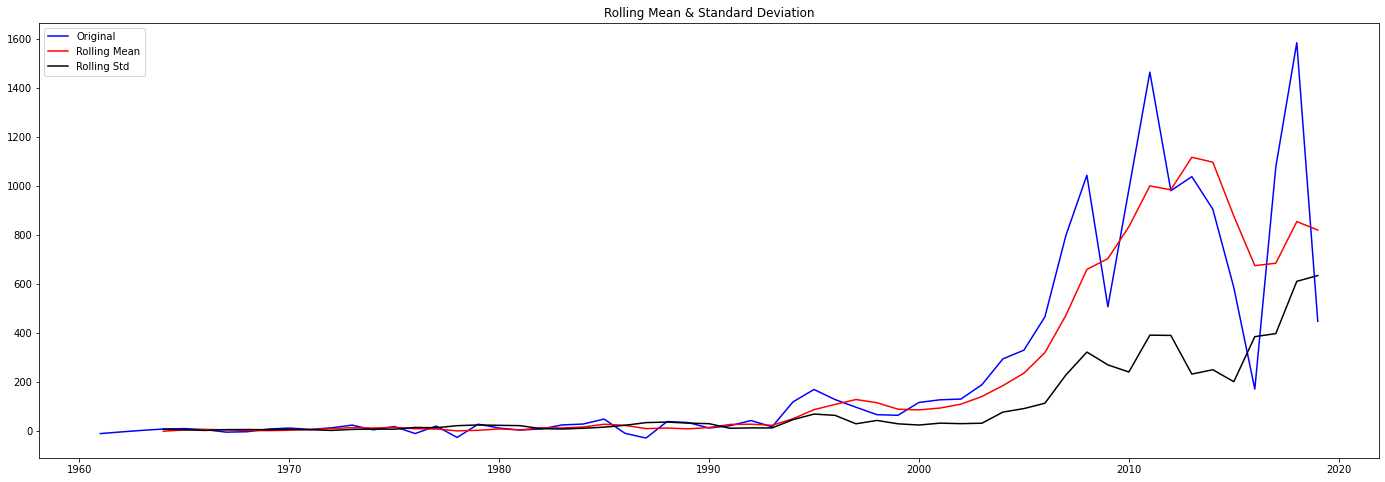

Results of Augmented Dickey-Fuller Test:
Test Statistic                  4.466157
p-value                         1.000000
#Lags Used                     11.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64
Results of LM Test:
Lagrange multiplier test statistic          4.453593e+01
The p-value for Lagrange multiplier test    5.853985e-06
The f statistic of the F test               4.207596e+01
The p-value of the F test.                  3.280439e-17
dtype: float64


In [4]:
#一阶差分对数序列的稳定性测试
GDP_diff1 = GDP_series.diff(1)
GDP_diff1.dropna(inplace=True)
test_stationarity(GDP_diff1)

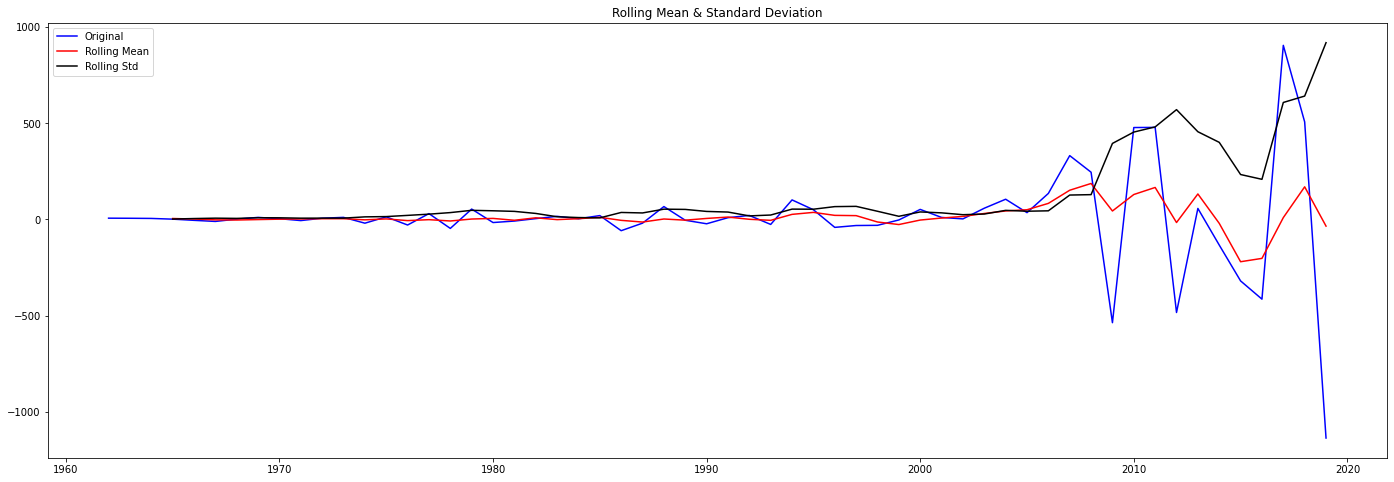

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -0.386533
p-value                         0.912323
#Lags Used                     11.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64
Results of LM Test:
Lagrange multiplier test statistic          3.638161e+01
The p-value for Lagrange multiplier test    1.461989e-04
The f statistic of the F test               1.090182e+01
The p-value of the F test.                  2.406616e-08
dtype: float64


In [5]:
#二阶差分对数序列的稳定性测试
GDP_diff2 = GDP_diff1.diff(1)
GDP_diff2.dropna(inplace=True)
test_stationarity(GDP_diff2)

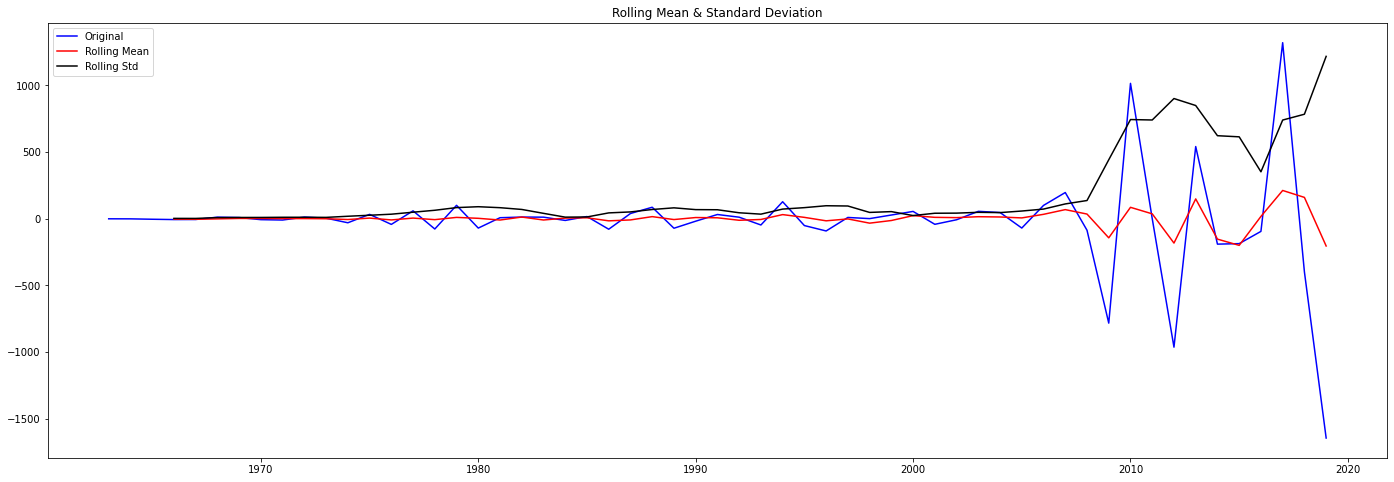

Results of Augmented Dickey-Fuller Test:
Test Statistic                -5.682666e+00
p-value                        8.416308e-07
#Lags Used                     1.100000e+01
Number of Observations Used    4.500000e+01
Critical Value (1%)           -3.584829e+00
Critical Value (5%)           -2.928299e+00
Critical Value (10%)          -2.602344e+00
dtype: float64
Results of LM Test:
Lagrange multiplier test statistic          4.122781e+01
The p-value for Lagrange multiplier test    2.201896e-05
The f statistic of the F test               2.670291e+01
The p-value of the F test.                  1.503425e-13
dtype: float64


In [6]:
#三阶差分对数序列的稳定性测试
GDP_diff3 = GDP_diff2.diff(1)
GDP_diff3.dropna(inplace=True)
test_stationarity(GDP_diff3)

In [7]:
#指数平均算法
def exp_ave(timeseries, degree='linear', alpha=0.1):
    '''
    Parameters:
        timeseries:
        degree: 只能是linear/quadratic/cubic中一种，代表一次、二次和三次
        alpha: 平滑指数
    Returns:
        pred_series: 预测序列
    '''
    if degree == 'linear':
        times = 1
    elif degree == 'quadratic':
        times = 2
    elif degree == 'cubic':
        times = 3
    else:
        return -1
    time_series_tmp = list(timeseries.values)
    S_result = [time_series_tmp] #存放所有计算的S^(1、2、3)的值
    for k in range(times):
        #保存预测值的列表
        S = []
        S.append(time_series_tmp[0])
        #做指数平滑依次预测
        for i in range(1, len(timeseries)):  #执行固定次数len(timeseries),不随循环增长
            new_pred = alpha* time_series_tmp[i] + (1-alpha)* S[i-1]
            S.append(new_pred)
        time_series_tmp = S
        S_result.append(S)
    #创建返回的pandas.Series()变量
    index = list(timeseries.index)
    pred_data = pd.DataFrame(np.array(S_result).T, index= index)     #pred_data是pd.DataFrame格式数据，第0列是原始数据，第1列为S^(1),
                                                                     #第2列为S^(2),第3列S^(3)  （s.t. 如果存在S^(2)、S^(3)的话）
    #根据结果计算预测值
    T = 1   #参数T的取值默认为1，即预测t+T时刻的值
    if degree == 'linear':    #一次指数平滑法（ppt15页）
        pred_series = pred_data.iloc[:,1]
    elif degree == 'quadratic':     #二次指数平滑法（ppt19页）
        a_q = 2* pred_data.iloc[:,1] - pred_data.iloc[:,2]
        b_q = alpha/(1-alpha) * (pred_data.iloc[:,1]-pred_data.iloc[:,2])
        pred_series = a_q + b_q*T
    elif degree == 'cubic':      #三次指数平滑法（ppt20页）
        a_c = 3* pred_data.iloc[:,1] - 3*pred_data.iloc[:,2] + pred_data.iloc[:,3]
        b_c = alpha/(2*(1-alpha)**2)* ((6-5*alpha)*pred_data.iloc[:,1] - 2*(5-4*alpha)*pred_data.iloc[:,2] + (4-3*alpha)*pred_data.iloc[:,3])
        c_c = alpha**2/(2*(1-alpha)**2)* (pred_data.iloc[:,1]- 2*pred_data.iloc[:,2] + pred_data.iloc[:,3])
        pred_series = a_c + T*b_c + T**2 * c_c
    pred_series.index += 1
    return pred_series

### 三阶差分后使用一次指数平滑
是否可用二或三次指数平滑？

In [8]:
#alpha设置为0.5（也许不是最优，需要寻找最优值）
GDP_diff3_pred = exp_ave(GDP_diff3, degree='linear', alpha=0.5)

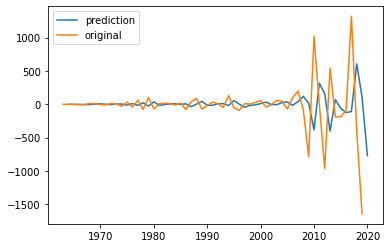

In [9]:
plt.figure()
plt.plot(GDP_diff3_pred, label= 'prediction')
plt.plot(GDP_diff3, label= 'original')
plt.legend(loc='best')
plt.show()

In [10]:
# 三阶差分还原
prediction_GDP_diff2 = GDP_diff3_pred.add(GDP_diff2.shift(1))[1:]
prediction_GDP_diff2[2020] = GDP_diff3_pred[2020]+ GDP_diff2[2019]

In [11]:
# 二阶差分还原
prediction_GDP_diff1 = prediction_GDP_diff2.add(GDP_diff1.shift(1))[2:]
prediction_GDP_diff1[2020] = prediction_GDP_diff2[2020]+ GDP_diff1[2019]

In [12]:
# 一阶差分还原
prediction_GDP = prediction_GDP_diff1.add(GDP_series.shift(1))[3:]
prediction_GDP[2020] = prediction_GDP_diff1[2020]+ GDP_series[2019]

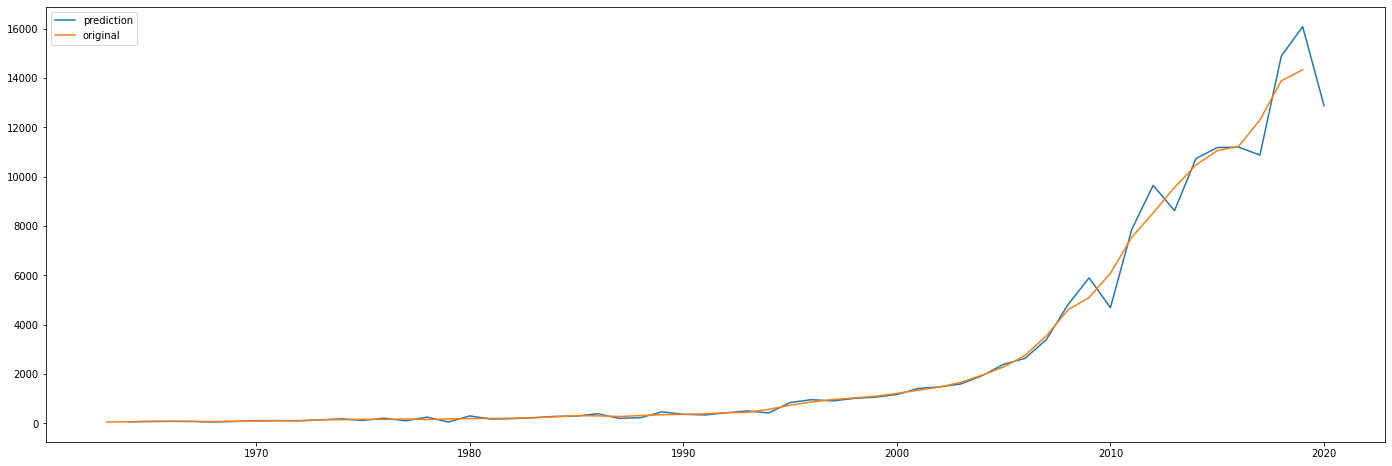

In [13]:
#三阶差分指数平滑预测图
plt.figure(figsize=(24, 8))
plt.plot(prediction_GDP, label= 'prediction')
plt.plot(GDP_series[3:], label= 'original')
plt.legend(loc='best')
plt.show()

In [14]:
#计算错误率
def error_rate(prediction, original):  
    return (prediction-original)/original

#错误率均方值
def error_rate_average(Error_rate):
    return ((Error_rate **2).sum())**0.5

#错误率统计图
def metrics_error_rate(prediction, original):
    #计算错误率，并绘制散点图 
    ERROR_RATE = error_rate(prediction, original)
    plt.figure(figsize=(24, 4))   
    plt.scatter(ERROR_RATE.index,ERROR_RATE,color='r')
    plt.grid(True)
    #绘制错误率直方图
    plt.figure(figsize=(4, 4))
    plt.hist(ERROR_RATE, bins=20)
    plt.grid(True)
    plt.show()
    return error_rate_average(ERROR_RATE)   #返回错误率均方值

### 三阶差分指数平滑预测错误率统计

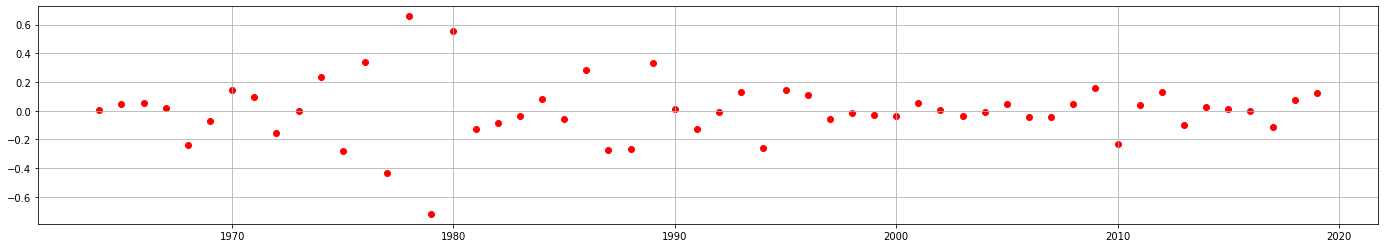

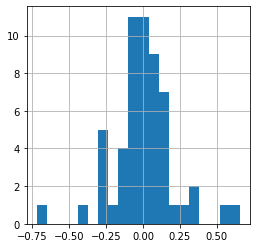

1.5743723625955892

In [15]:
metrics_error_rate(prediction_GDP, GDP_series)

## 原始数据使用三次指数平滑

In [16]:
#直接使用GDP_series做三次指数平滑预测
linear_prediction_GDP = exp_ave(GDP_series, degree='linear', alpha=0.5)
quadratic_prediction_GDP = exp_ave(GDP_series, degree='quadratic', alpha=0.5)
cubic_prediction_GDP = exp_ave(GDP_series, degree='cubic', alpha=0.5)

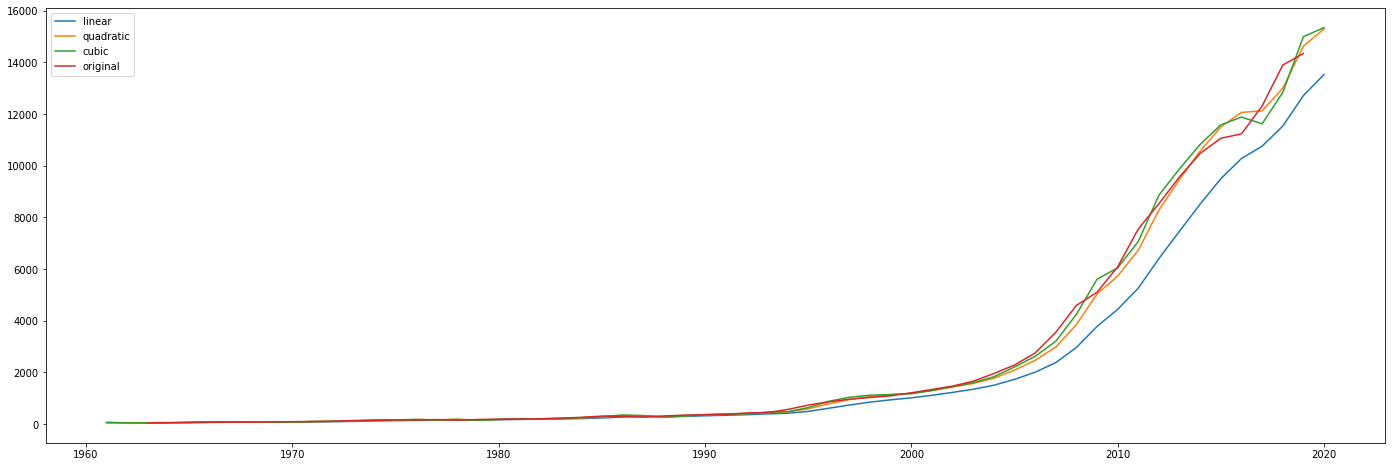

In [17]:
#原数据三次指数平滑预测图
plt.figure(figsize=(24, 8))
plt.plot(linear_prediction_GDP, label= 'linear')
plt.plot(quadratic_prediction_GDP, label= 'quadratic')
plt.plot(cubic_prediction_GDP, label= 'cubic')
plt.plot(GDP_series[3:], label= 'original')
plt.legend(loc='best')
plt.show()

### 三次指数平滑预测错误率统计

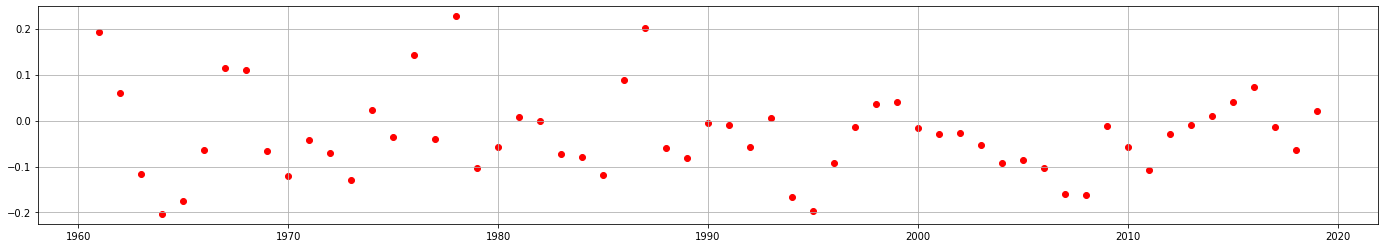

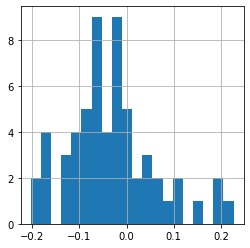

0.7519318348626166

In [18]:
metrics_error_rate(quadratic_prediction_GDP, GDP_series)

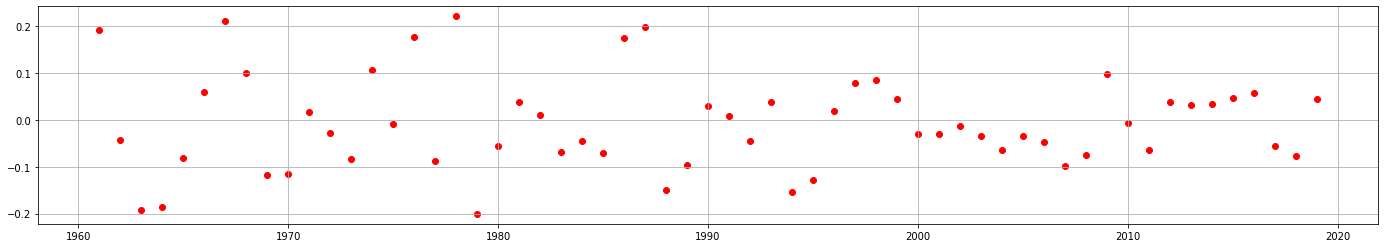

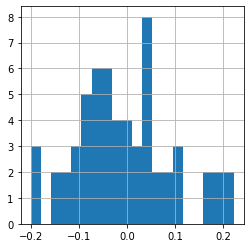

0.7683741779585502

In [19]:
metrics_error_rate(cubic_prediction_GDP, GDP_series)

## 使用Holt-Winters方法预测

In [20]:
from statsmodels.tsa.holtwinters import Holt   #具体算法请查询官方文档
holt = Holt(GDP_series)
holt_fit = holt.fit(smoothing_level = 0.4)

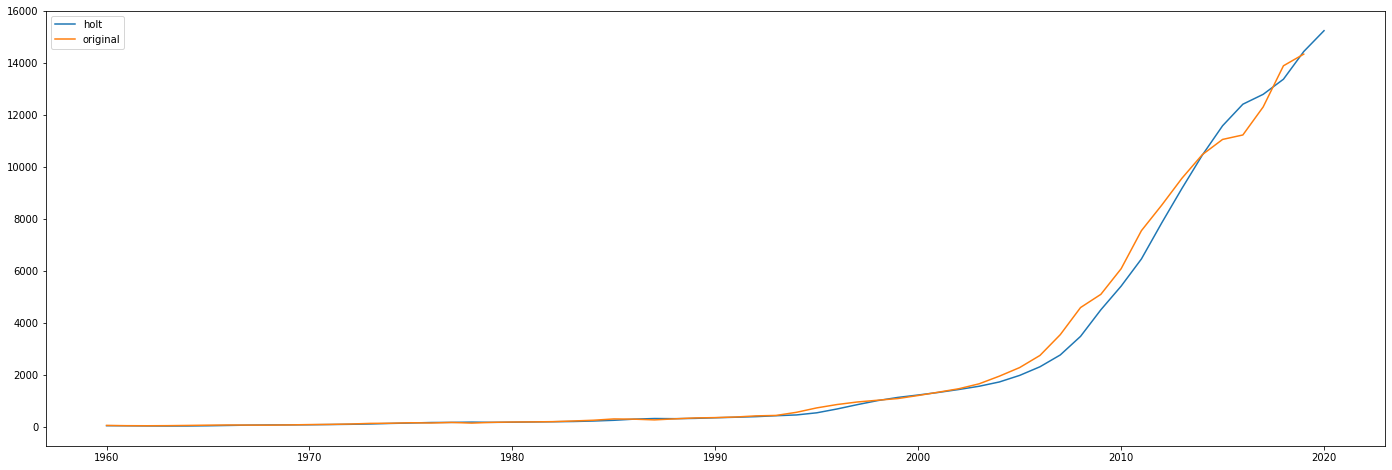

In [21]:
holt_forecast = holt_fit.forecast(1)
holt_forecast.index += 1960
holt_prediction = holt_fit.fittedvalues.append(holt_forecast)
plt.figure(figsize=(24, 8))
plt.plot(holt_prediction, label= 'holt')
plt.plot(GDP_series, label= 'original')
plt.legend(loc='best')
plt.show()

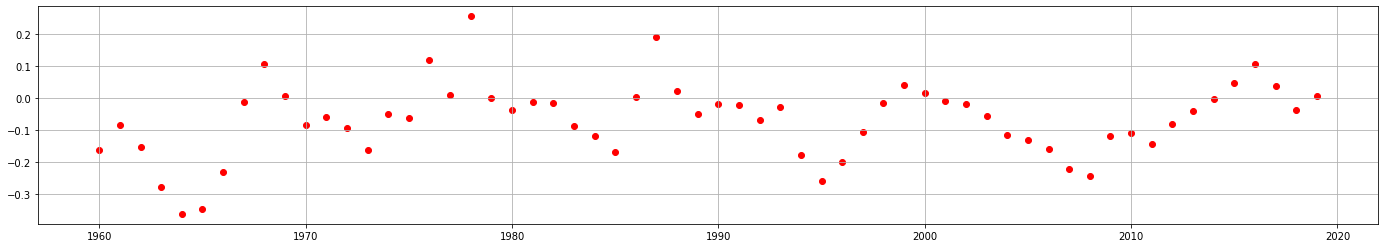

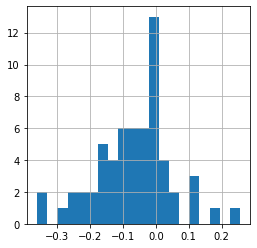

1.032008766427157

In [22]:
metrics_error_rate(holt_prediction, GDP_series)